# Bootstrap Ranking

In [1]:
%load_ext autoreload
%autoreload 2

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from htc.context.models.context_evaluation import compare_context_runs, glove_runs
from htc.context.models.visualization import ranking_figure, ranking_legend
from htc.context.settings_context import settings_context
from htc.evaluation.ranking import BootstrapRanking
from htc.fonts.set_font import set_font
from htc.models.common.torch_helpers import move_batch_gpu
from htc.models.common.transforms import HTCTransformation
from htc.models.image.DatasetImage import DatasetImage
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config

set_font(24)

In [2]:
task_mapping = {k: v for k, v in settings_context.task_name_mapping.items() if k not in ["semantic", "no-glove"]}

runs = settings_context.best_transform_runs.values()
df = compare_context_runs(runs, test=True)
df = df.query("dataset in @task_mapping.keys()")
df.replace({"network": r"context_([^\d]+)_.*"}, {"network": r"\1"}, regex=True, inplace=True)

# Add results for the glove dataset
df = pd.concat([df, glove_runs()])
df

network      dataset  label_index  dice_metric  \
0        baseline  isolation_0            6     0.394795   
1        baseline  isolation_0            5     0.991183   
2        baseline  isolation_0            4     0.844978   
3        baseline  isolation_0            3     0.962162   
4        baseline  isolation_0            8     0.291082   
..            ...          ...          ...          ...   
14  hide_and_seek        glove           15     0.918878   
15  hide_and_seek        glove           11     0.516361   
16  hide_and_seek        glove           17     0.609840   
17  hide_and_seek        glove           18     0.785634   
18  hide_and_seek        glove            0     0.926802   

    surface_distance_metric  surface_dice_metric_mean  \
0                 67.887348                  0.532504   
1                  0.457608                  0.978562   
2                 17.273128                  0.778292   
3                  0.775067                  0.887313   
4                431.775469                  0.003813   
..                      ...                       ...   
14                 4.918161                  0.499119   
15                63.708439                  0.589943   
16                12.951227                  0.771356   
17                 6.502438                  0.331605   
18                 4.326813                  0.782618   

                    label_name  
0                      stomach  
1                  small_bowel  
2                        colon  
3                        liver  
4                  gallbladder  
..                         ...  
14                      muscle  
15                  peritoneum  
16                  major_vein  
17  kidney_with_Gerotas_fascia  
18                  background  

[903 rows x 7 columns]

In [3]:
np.random.seed(0)
ranking = BootstrapRanking(df, task="dataset", algorithm="network", case="label_name", value="dice_metric")
df_bootstraps = ranking.bootstraps
df_counts = ranking.counts
df_statistics = ranking.statistics
n_bootstraps = df_bootstraps.bootstrap.max()
df_bootstraps

bootstrap         task              algorithm rank
0             1  isolation_0               baseline    7
0             1  isolation_0  organ_transplantation    1
0             1  isolation_0                cut_mix    3
0             1  isolation_0                 jigsaw    4
0             1  isolation_0         random_erasing    2
...         ...          ...                    ...  ...
6999       1000        glove                cut_mix    1
6999       1000        glove                 jigsaw    2
6999       1000        glove                elastic    5
6999       1000        glove         random_erasing    3
6999       1000        glove          hide_and_seek    6

[49000 rows x 4 columns]

### Plot the ranking across test datasets:

In [4]:
df_statistics_renamed = df_statistics.replace({"task": task_mapping})
task_selection = task_mapping.values()
task_order = [t for t in task_mapping.values() if t in task_selection]
df_statistics_renamed = df_statistics_renamed.query("task in @task_selection")
df_statistics_renamed = df_statistics_renamed.sort_values(
    by="task", key=lambda column: column.map(lambda e: list(task_mapping.values()).index(e))
)

[WARNING][py.warnings] /tmp/ipykernel_239766/2192524145.py:19: UserWarning: FixedFormatter should only   warnings.py:109
be used together with FixedLocator                                                                                      
  ax.set_xticklabels(task_order, rotation=90, size=new_font_size)                                                       
                                                                                                                        

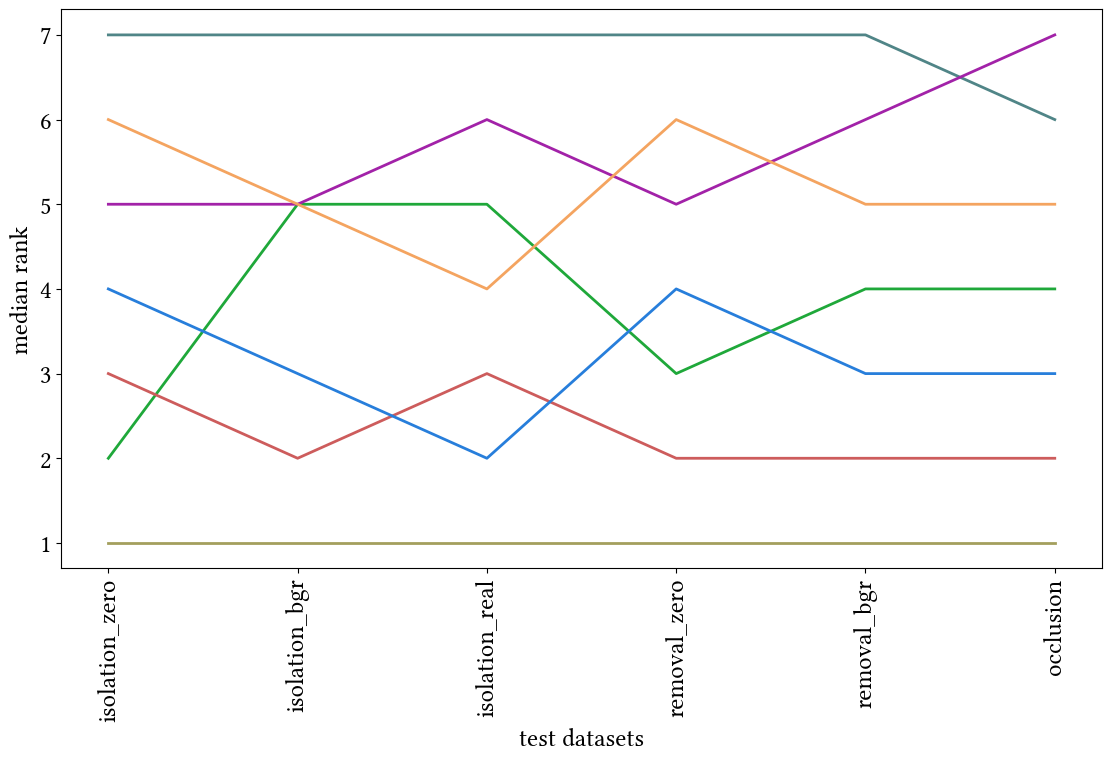

In [5]:
new_font_size = 18

fig, ax = plt.subplots(1, 1, figsize=(11, 7.5), constrained_layout=True, sharex=True)
sns.lineplot(
    df_statistics_renamed,
    x="task",
    y="median_rank",
    hue="algorithm",
    palette=settings_context.augmentation_colors,
    linewidth=2,
    ax=ax,
)
ax.get_legend().set_visible(False)
y_min, y_max = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(1, 8, 1))
ax.set_yticklabels(np.arange(1, 8, 1), size=new_font_size)
ax.set_ylabel("median rank", size=new_font_size)
ax.set_xlabel("test datasets", size=new_font_size)
ax.set_xticklabels(task_order, rotation=90, size=new_font_size)
# plt.savefig(settings_context.paper_dir / "ranking_compact.pdf", bbox_inches="tight");

### Bubble plots per test dataset:

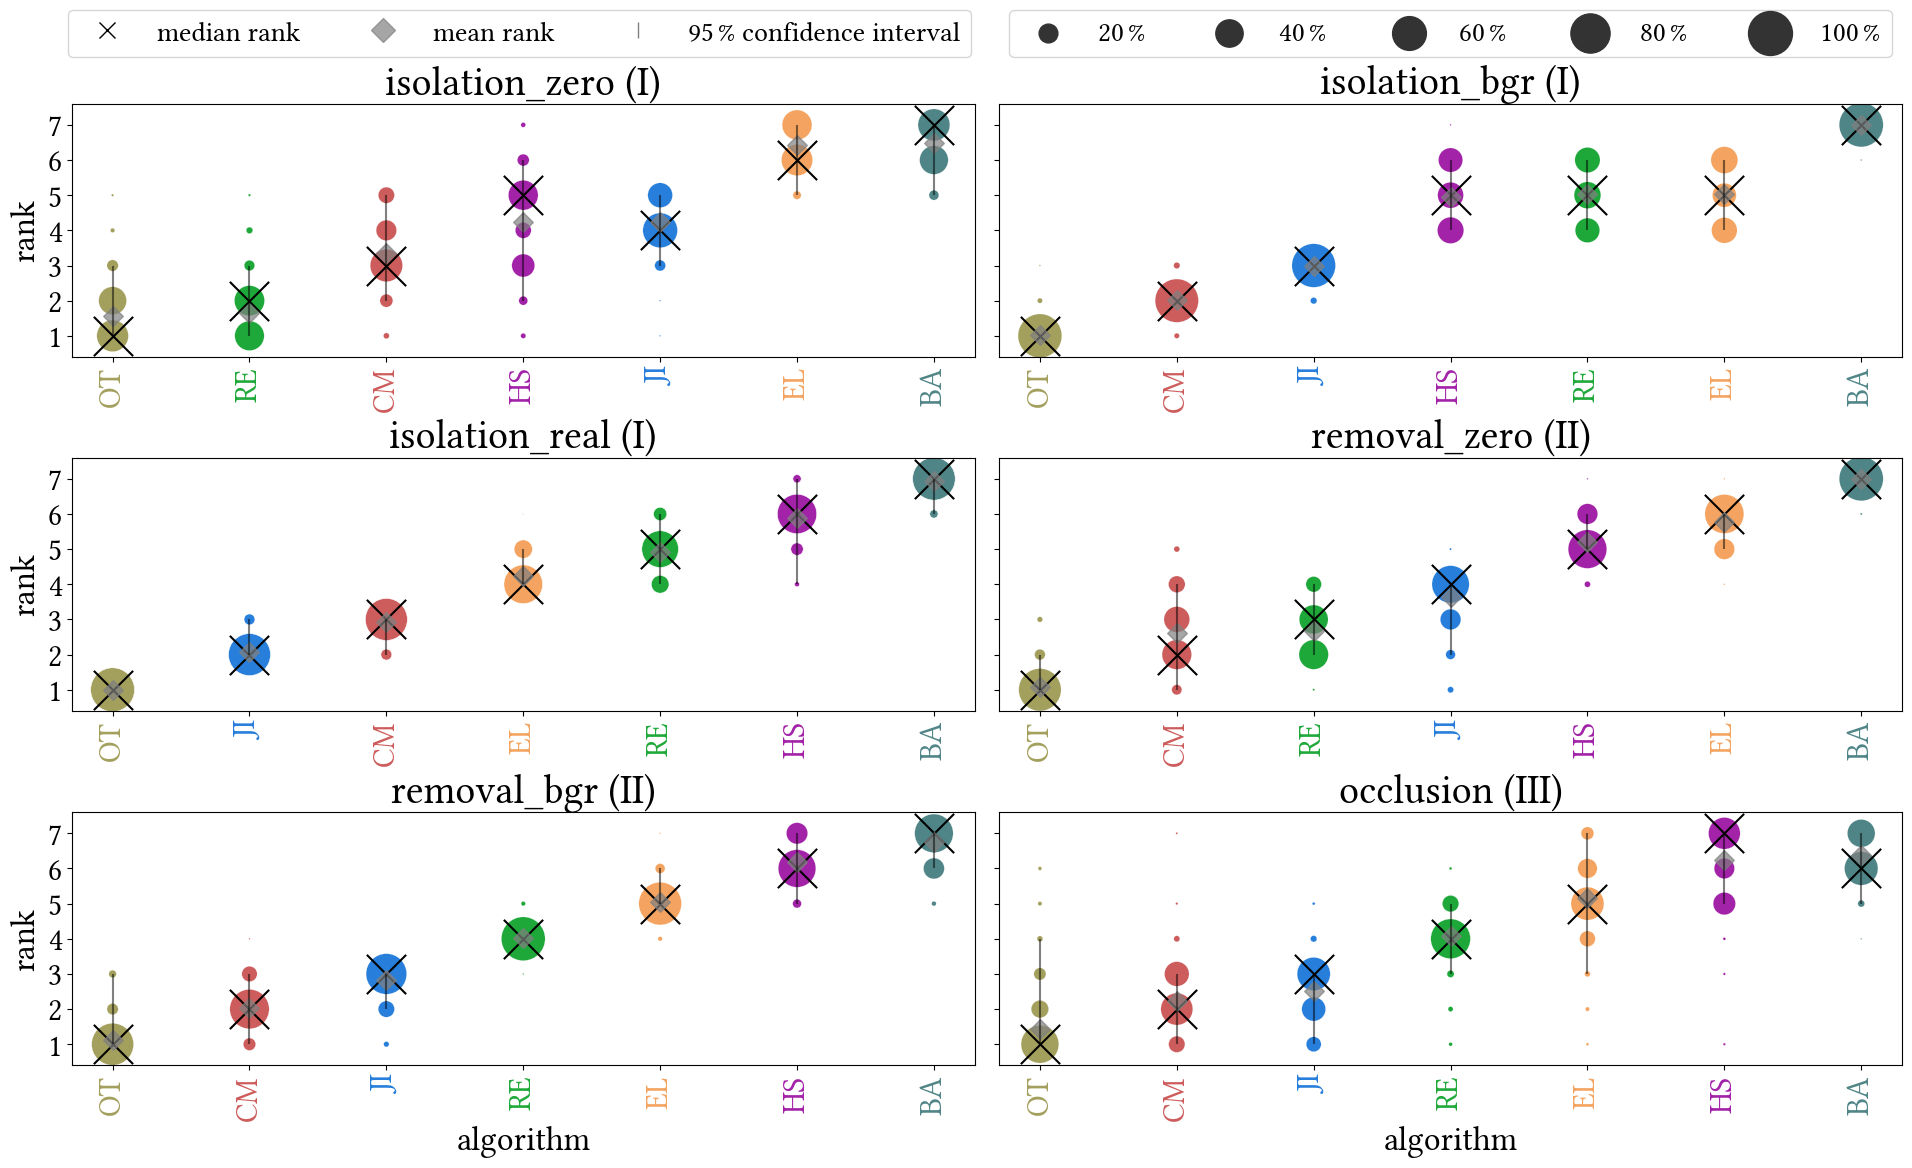

In [6]:
fig = ranking_figure(ranking, task_mapping)
fig.savefig(settings_context.paper_dir / "ranking_DSC.pdf", bbox_inches="tight");

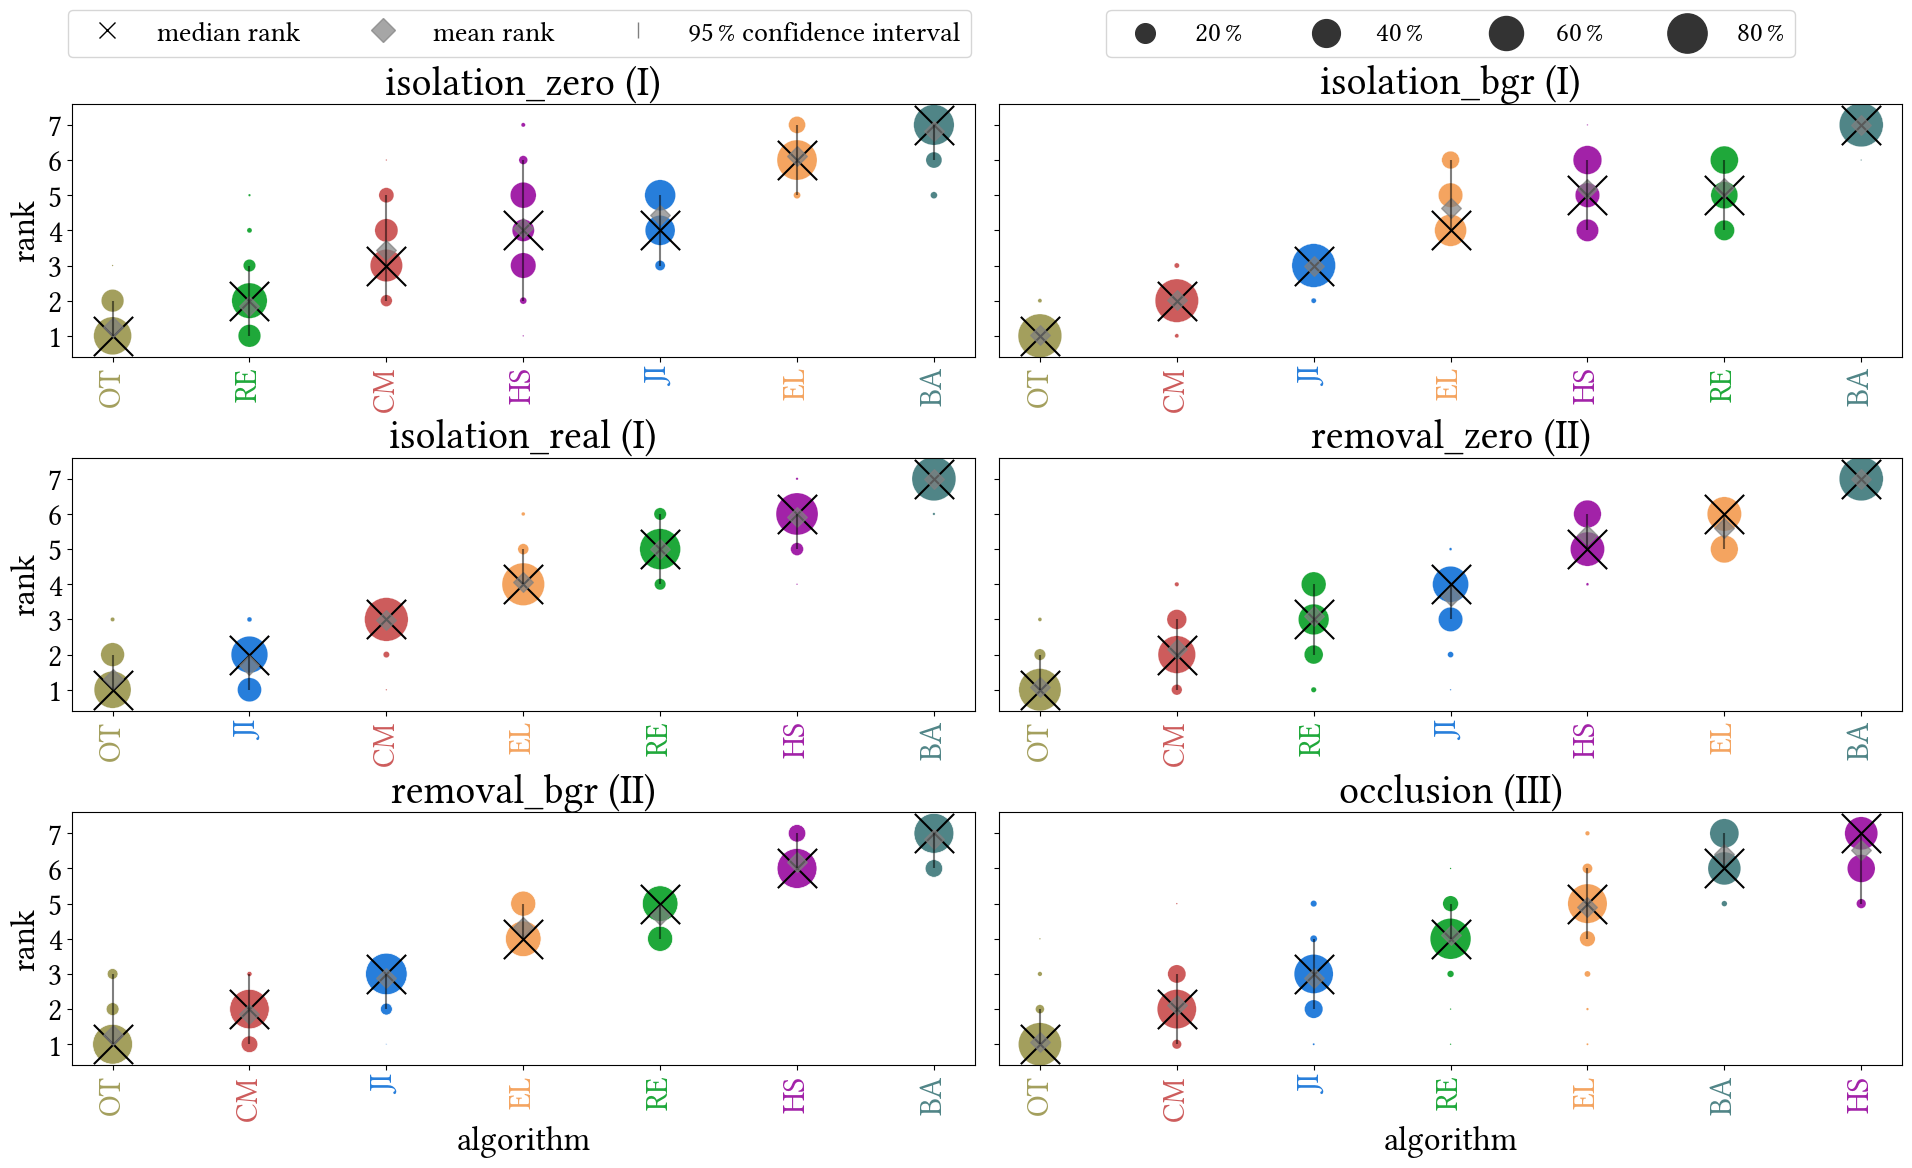

In [7]:
np.random.seed(0)
ranking_nsd = BootstrapRanking(
    df, task="dataset", algorithm="network", case="label_name", value=settings_seg.nsd_aggregation_short
)
fig = ranking_figure(ranking_nsd, task_mapping)
fig.savefig(settings_context.paper_dir / "ranking_NSD.pdf", bbox_inches="tight");

In [8]:
# overall ranking across tasks (mean of mean rankings):
df_overall = (
    df_statistics.groupby("algorithm", as_index=True)["mean_rank"].mean().reset_index().sort_values("mean_rank")
)
df_overall

algorithm  mean_rank
5  organ_transplantation   1.443000
1                cut_mix   2.380286
4                 jigsaw   3.024429
6         random_erasing   3.650143
3          hide_and_seek   5.353429
2                elastic   5.357000
0               baseline   6.791714

## Augmentation Samples
### Organ Transplantation Examples

In [9]:
# We include the augmentation sample generation in this notebook because we need the ranking results for the legend figure

torch.manual_seed(42)
config = Config(
    {
        "input/n_channels": 3,
        "input/transforms_gpu": [
            {
                "class": "htc.context.context_transforms>OrganTransplantation",
                "p": 1,
            }
        ],
        "label_mapping": settings_seg.label_mapping,
    }
)

example_paths = [
    DataPath.from_image_name("P047#2020_02_07_17_29_03"),
    DataPath.from_image_name("P070#2020_07_24_19_57_13"),
    DataPath.from_image_name("P044#2020_02_01_09_58_04"),
    DataPath.from_image_name("P068#2020_07_20_18_22_06"),
    DataPath.from_image_name("P041#2019_12_14_12_01_09"),
    DataPath.from_image_name("P057#2020_03_13_18_44_07"),
    DataPath.from_image_name("P061#2020_05_15_10_28_04"),
    DataPath.from_image_name("P072#2020_08_08_12_56_21"),
    DataPath.from_image_name("P045#2020_02_05_10_54_19"),
]

dataset = DatasetImage(example_paths, train=False, config=config)
dataloader = DataLoader(dataset, batch_size=len(example_paths))

batch = next(iter(dataloader))
batch_copy = copy.deepcopy(batch)

batch = move_batch_gpu(batch)
aug = HTCTransformation.parse_transforms(config["input/transforms_gpu"], config=config)
batch_transformed = HTCTransformation.apply_valid_transforms(batch, aug)

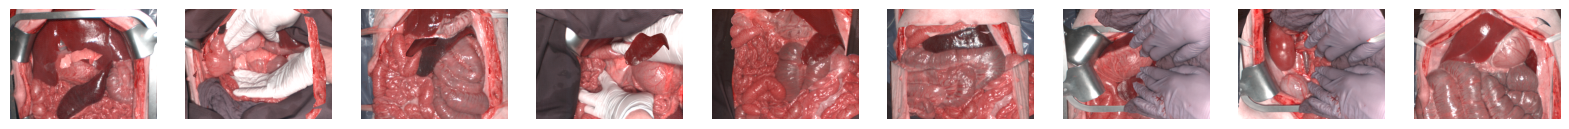

In [10]:
fig, ax = plt.subplots(ncols=len(example_paths), figsize=(20, 5))
for i in np.arange(len(example_paths)):
    ax[i].imshow(batch_transformed["features"][i].cpu())
    ax[i].axis("off")

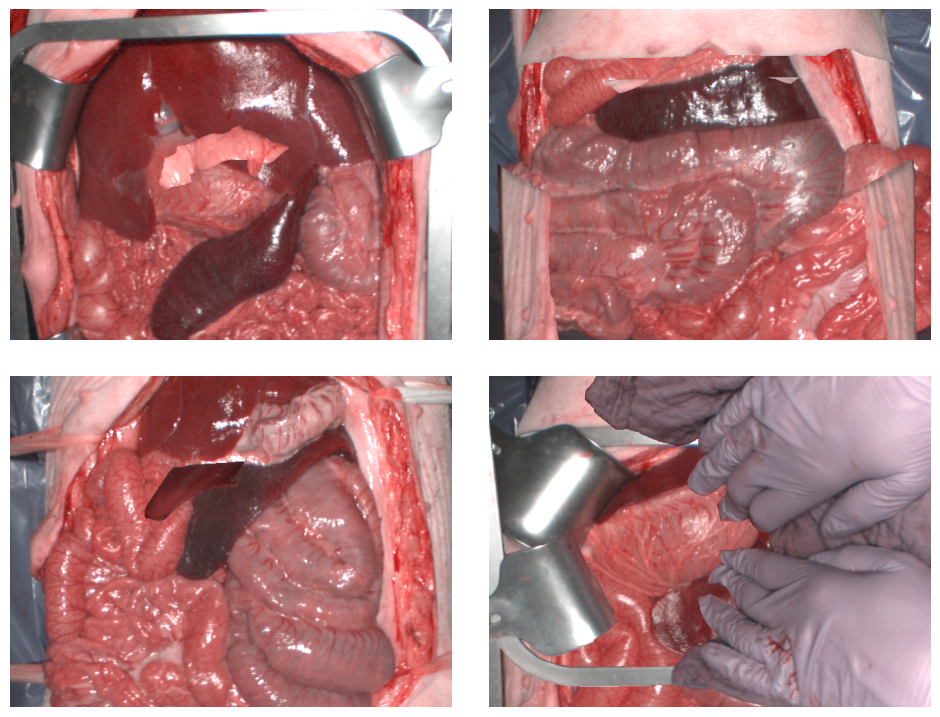

In [11]:
selection = [0, 5, 2, 6]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7.7), tight_layout=True)
for i, s in enumerate(selection):
    ax[i // 2, i % 2].imshow(batch_transformed["features"][s].cpu())
    ax[i // 2, i % 2].axis("off")

plt.savefig(settings_context.paper_dir / "sample_augmentations.pdf")

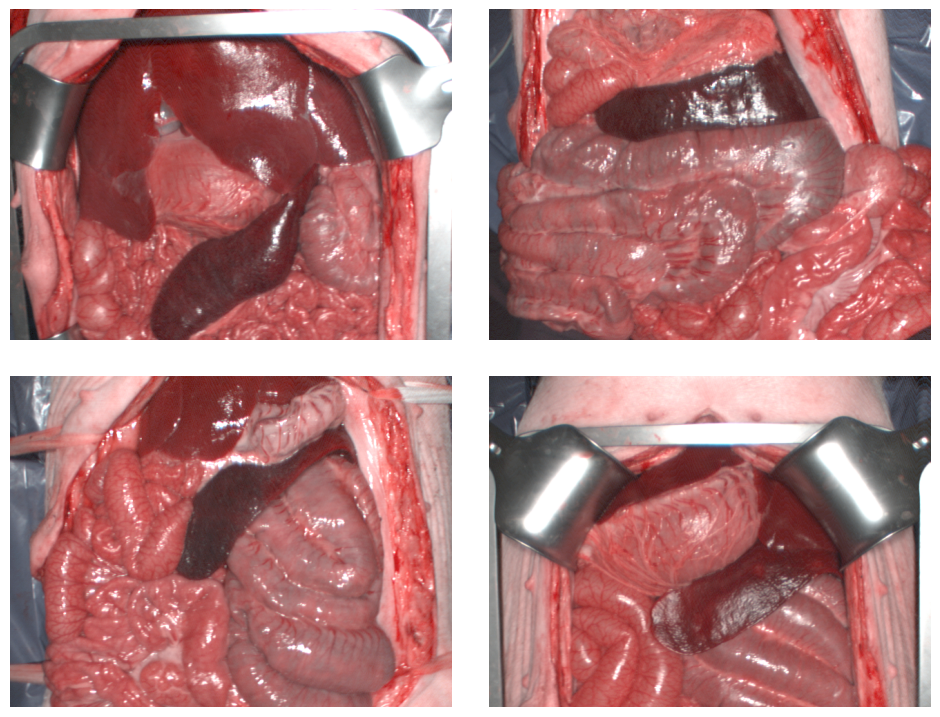

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7.7), tight_layout=True)
for i, s in enumerate(selection):
    ax[i // 2, i % 2].imshow(batch_copy["features"][s].cpu())
    ax[i // 2, i % 2].axis("off")

plt.savefig(settings_context.paper_dir / "sample_baseline.pdf")

### Ranking Legend

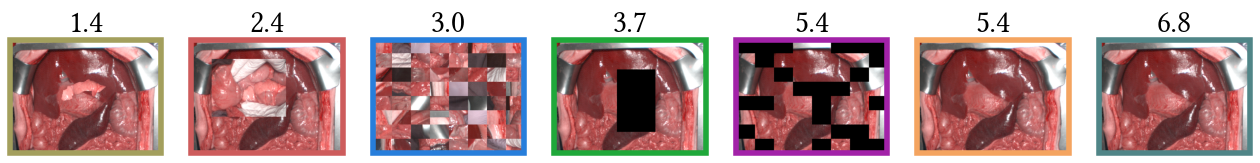

In [13]:
example_paths = [
    DataPath.from_image_name("P047#2020_02_07_17_29_03"),
    DataPath.from_image_name("P070#2020_07_24_19_57_13"),
    DataPath.from_image_name("P044#2020_02_01_09_58_04"),
    DataPath.from_image_name("P068#2020_07_20_18_22_06"),
    DataPath.from_image_name("P041#2019_12_14_12_01_09"),
    DataPath.from_image_name("P057#2020_03_13_18_44_07"),
    DataPath.from_image_name("P061#2020_05_15_10_28_04"),
    DataPath.from_image_name("P072#2020_08_08_12_56_21"),
    DataPath.from_image_name("P045#2020_02_05_10_54_19"),
]

trans_images = {}
selected_image = 0

for name, trans in settings_context.transforms.items():
    if name == "elastic":
        torch.manual_seed(0)
    elif name == "cut_mix":
        torch.manual_seed(1)
    else:
        torch.manual_seed(42)

    trans = copy.deepcopy(trans)
    trans["p"] = 1
    config = Config(
        {
            "input/n_channels": 3,
            "input/transforms_gpu": [trans],
            "label_mapping": settings_seg.label_mapping,
        }
    )

    dataset = DatasetImage(example_paths, train=False, config=config)
    dataloader = DataLoader(dataset, batch_size=len(example_paths))
    batch = next(iter(dataloader))

    batch_gpu = move_batch_gpu(batch)
    aug = HTCTransformation.parse_transforms(config["input/transforms_gpu"], config=config)
    batch_transformed = HTCTransformation.apply_valid_transforms(batch_gpu, aug)

    trans_images[name] = batch_transformed["features"][selected_image].cpu()

trans_images["baseline"] = batch["features"][0]

fig = ranking_legend(df_overall["algorithm"].tolist(), df_overall["mean_rank"].tolist(), trans_images)
fig.savefig(settings_context.paper_dir / "augmentation_legend_DSC.pdf", bbox_inches="tight", dpi=300)

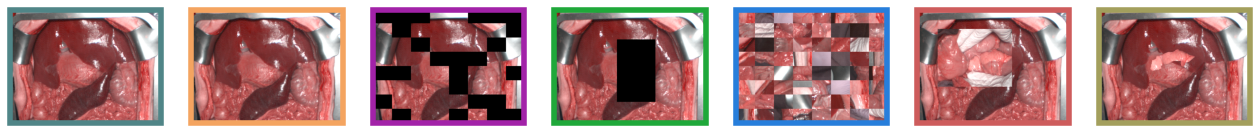

In [14]:
df_overall_r = df_overall.sort_values(by="mean_rank", ascending=False)
fig, ax = plt.subplots(ncols=len(trans_images), figsize=(16, 8))
for i, (name, rank) in enumerate(zip(df_overall_r["algorithm"], df_overall_r["mean_rank"])):
    ax[i].imshow(trans_images[name])
    ax[i].axis("off")

    bbox = ax[i].get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    fig.add_artist(
        plt.Rectangle(
            (x0, y0), width, height, edgecolor=settings_context.augmentation_colors[name], linewidth=4, fill=False
        )
    )

fig.savefig(settings_context.paper_dir / "augmentation_legend_DSC_inverse.pdf", bbox_inches="tight", dpi=300)

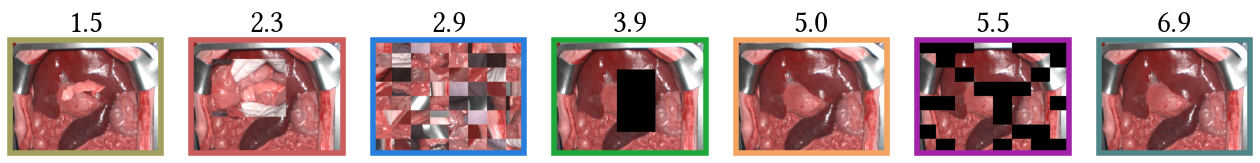

In [15]:
df_overall_nsd = (
    ranking_nsd.statistics.groupby("algorithm", as_index=True)["mean_rank"]
    .mean()
    .reset_index()
    .sort_values("mean_rank")
)
fig = ranking_legend(df_overall_nsd["algorithm"].tolist(), df_overall_nsd["mean_rank"].tolist(), trans_images)
fig.savefig(settings_context.paper_dir / "augmentation_legend_NSD.pdf", bbox_inches="tight", dpi=300)